<a href="https://colab.research.google.com/github/colivarese/CarSCAN/blob/main/CarSCAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Kaggle Dependecy

In [1]:
pip install kaggle

# Set Kaggle API Token 

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


# Download the dataset

In [3]:
!kaggle datasets download "ruby09/damage-detection-dataset"

 35% 5.00M/14.4M [00:00<00:01, 7.35MB/s]
100% 14.4M/14.4M [00:00<00:00, 19.8MB/s]


In [4]:
!unzip damage-detection-dataset.zip

Archive:  damage-detection-dataset.zip
  inflating: img/1.jpg               
  inflating: img/10.jpg              
  inflating: img/13.jpg              
  inflating: img/14.jpg              
  inflating: img/15.jpg              
  inflating: img/16.jpg              
  inflating: img/17.jpg              
  inflating: img/18.jpg              
  inflating: img/19.jpg              
  inflating: img/2.jpg               
  inflating: img/20.jpg              
  inflating: img/21.jpg              
  inflating: img/22.jpg              
  inflating: img/23.jpg              
  inflating: img/24.jpg              
  inflating: img/25.jpg              
  inflating: img/26.jpg              
  inflating: img/27.jpg              
  inflating: img/29.jpg              
  inflating: img/3.jpg               
  inflating: img/30.jpg              
  inflating: img/31.jpg              
  inflating: img/32.jpg              
  inflating: img/33.jpg              
  inflating: img/34.jpg              
  inflating

# Installing Detectron2

In [5]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-q96vqwr5
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-q96vqwr5
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 37.5 MB/s 
     |████████████████████████████████| 130 kB 52.5 MB/s 
     |████████████████████████████████| 843 kB 47.7 MB/s 
     |████████████████████████████████| 749 kB 40.4 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 112 kB 48.9 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5679290 sha256=4f5b3d08929d0c00cd49d25db01c2884cfcade7338964e7446a294bb4a23114f
  Stored in directory: /tmp/pip-ephem-wheel-cache-x9x2dpj5/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

In [6]:
import torch, torchvision
print(torch.cuda.is_available())
import os, pickle ,random

True


In [7]:
#!pip install pyyaml==5.1

#import torch
#TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
#CUDA_VERSION = torch.__version__.split("+")[-1]
#print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

# Import some common Detectron2 dependencies

In [8]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [9]:
register_coco_instances('Training data',
                        metadata = dict(),
                        json_file = "./train/COCO_train_annos.json",
                        image_root = "./train"
                        )

# Data Augmentation

In [12]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Some data visualization

[01/07 05:12:30 d2.data.datasets.coco]: Loaded 59 images in COCO format from ./train/COCO_train_annos.json


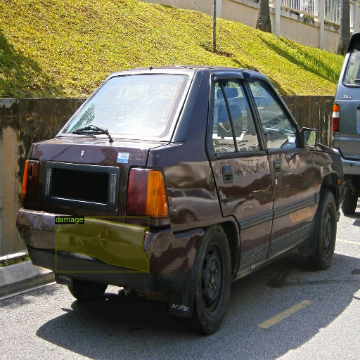

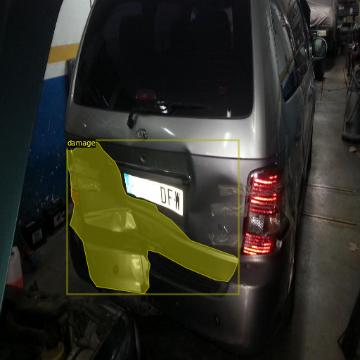

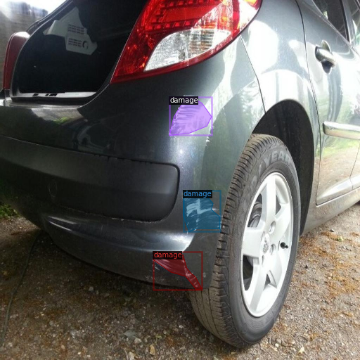

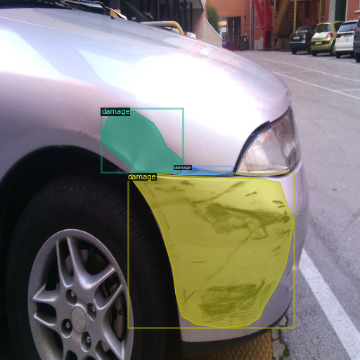

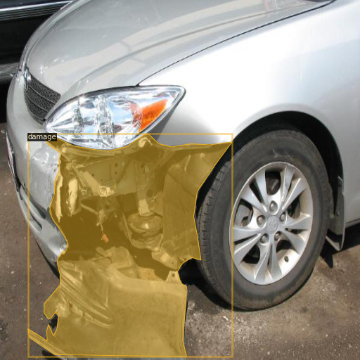

In [14]:
number_of_samples = 4

dataset_dicts= DatasetCatalog.get('Training data')
crash_metadata = MetadataCatalog.get('Training data')

for d in random.sample(dataset_dicts, number_of_samples+1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=crash_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(cv2.resize(out.get_image()[:, :, ::-1], (360,360)))
    #cv2.resize(im, (960, 540))  

# Training a pre-trained Detectron2 Model

In [16]:
from detectron2.engine import DefaultTrainer

#from detectron2.config import get_cfg


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Training data",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 800   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/07 05:17:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/07 05:17:37 d2.engine.train_loop]: Starting training from iteration 0
[01/07 05:17:57 d2.utils.events]:  eta: 0:13:02  iter: 19  total_loss: 2.057  loss_cls: 0.8062  loss_box_reg: 0.3552  loss_mask: 0.6921  loss_rpn_cls: 0.155  loss_rpn_loc: 0.02174  time: 0.9792  data_time: 0.0214  lr: 2.4726e-05  max_mem: 3243M
[01/07 05:18:17 d2.utils.events]:  eta: 0:12:49  iter: 39  total_loss: 1.802  loss_cls: 0.5498  loss_box_reg: 0.4465  loss_mask: 0.6836  loss_rpn_cls: 0.1572  loss_rpn_loc: 0.01788  time: 0.9895  data_time: 0.0088  lr: 4.9701e-05  max_mem: 3243M
[01/07 05:18:35 d2.utils.events]:  eta: 0:12:22  iter: 59  total_loss: 1.558  loss_cls: 0.3465  loss_box_reg: 0.3572  loss_mask: 0.6586  loss_rpn_cls: 0.06883  loss_rpn_loc: 0.0179  time: 0.9718  data_time: 0.0097  lr: 7.4676e-05  max_mem: 3243M
[01/07 05:18:55 d2.utils.events]:  eta: 0:12:08  iter: 79  total_loss: 1.654  loss_cls: 0.3876  loss_box_reg: 0.475  loss_mask: 0.6395  loss_rpn_cls: 0.08759  loss_rpn_loc: 0.02359  time: 0

# Inference with the trained model

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Set validation data

In [18]:
register_coco_instances('Validation data',
                        metadata = dict(),
                        json_file = "./val/COCO_val_annos.json",
                        image_root = "./val"
                        )

AssertionError: ignored

[01/07 05:31:56 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./val/COCO_val_annos.json


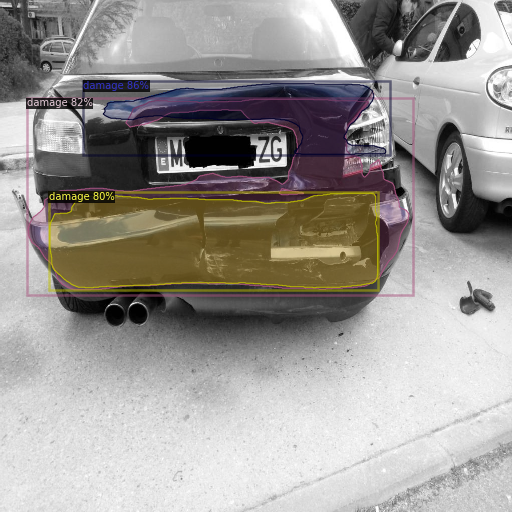

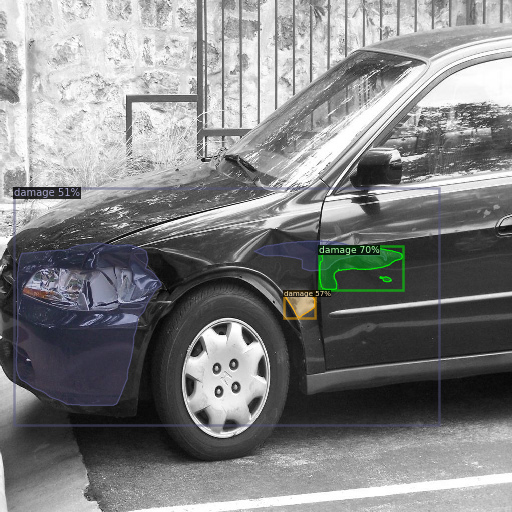

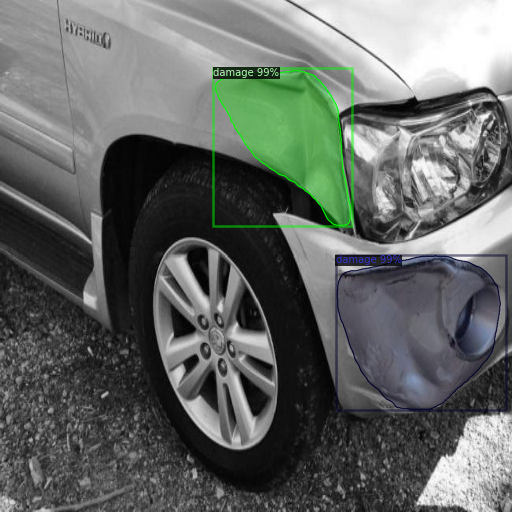

In [19]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts= DatasetCatalog.get('Validation data')
val_crash_metadata = MetadataCatalog.get('Validation data')

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_crash_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# Evaluate the model using AP

In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [21]:
evaluator = COCOEvaluator("Validation data", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "Validation data")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[01/07 05:32:54 d2.data.datasets.coco]: Loaded 11 images in COCO format from ./val/COCO_val_annos.json
[01/07 05:32:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   damage   | 24           |
|            |              |
[01/07 05:32:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/07 05:32:54 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[01/07 05:32:54 d2.data.common]: Serialized dataset takes 0.01 MiB
[01/07 05:32:54 d2.evaluation.evaluator]: Start inference on 11 batches
[01/07 05:32:58 d2.evaluation.evaluator]: Inference done 11/11. Dataloading: 0.0014 s/iter. Inference: 0.2871 s/iter. Eval: 0.0127 s/iter. Total: 0.3011 s/iter. ETA=0:00:00
[01/07 05:32:58 d2.evaluation.evaluator]: Total inference time: 0:00:01.869251 (0.311542 s / iter pe